In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import pickle
import cv2
import os

In [26]:
from PIL import Image
import numpy as np
import tarfile
import matplotlib.pyplot as plt

In [27]:
# unpickling the annotation files
train_annotation = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/train_annotation.pkl', 'rb'))
test_annotation = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_annotation.pkl', 'rb'))
test_dev_annotation = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_dev_annotation.pkl', 'rb'))

In [28]:
file = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_train.tar')
file.extractall('/content/vehicle_images')
file.close()

In [29]:
file = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_test.tar')
file.extractall('/content/vehicle_images')
file.close()

In [30]:
file = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_dev.tar')
file.extractall('/content/vehicle_images')
file.close()

In [31]:
import os
import shutil

src = '/content/vehicle_images/images_train/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [32]:
src = '/content/vehicle_images/images_test/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [33]:
src = '/content/vehicle_images/images_dev/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [34]:
train_annotation.keys(), test_annotation.keys(), test_dev_annotation.keys()

(dict_keys(['train_im_names', 'wheel_label', 'type_label', 'color_label', 'luggage_label', 'd_part_label', 'sky_label', 'bumper_label']),
 dict_keys(['query_order', 'wheel_label', 'type_label', 'gallery_order', 'color_label', 'luggage_label', 'd_part_label', 'test_im_names', 'bumper_label', 'sky_label']),
 dict_keys(['query_order', 'wheel_label', 'dev_im_names', 'type_label', 'color_label', 'luggage_label', 'd_part_label', 'sky_label', 'bumper_label', 'gallery_order']))

In [35]:
annotations = {}
for ind in train_annotation['type_label']:
    img_name = train_annotation['train_im_names'][ind]
    annotations[img_name] = train_annotation['type_label'][ind]

In [36]:
annotations.update(test_annotation['type_label'])
annotations.update(test_dev_annotation['type_label'])

In [37]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [38]:
Counter(annotations.values())

Counter({0: 61227, 1: 5551, 2: 42675, 3: 2834, 4: 15398, 5: 9567, 6: 158})

In [39]:
strategy = {0:1500, 1:950, 2:1500, 3:700, 4:1300, 5:1150, 6:0}
undersample = RandomUnderSampler(sampling_strategy = strategy)
X1, y1 = np.array(list(annotations.keys())), np.array(list(annotations.values()))
X1 = X1.reshape(-1,1)
y1 = y1.reshape(-1,1)
annot_name1, annot_label1 = undersample.fit_resample(X1, y1)
Counter(annot_label1)

Counter({0: 1500, 1: 950, 2: 1500, 3: 700, 4: 1300, 5: 1150})

In [40]:
annot_name1

array([['LMRMB40U_C1.jpg'],
       ['SDUCT9SP_C1.jpg'],
       ['N351Z2AW_C1.jpg'],
       ...,
       ['UJI9WHM0_C2.jpg'],
       ['BKA2KNEX_C1.jpg'],
       ['WIEZL84F_C2.jpg']], dtype='<U26')

In [41]:
img_data, labels = [], []
path ='/content/vehicle_images/'
for file in annot_name1:
  img_arr = cv2.imread(os.path.join(path, file[0]))[...,::-1] #convert BGR to RGB format
  resized_arr = cv2.resize(img_arr, (224, 224))
  img_data.append(resized_arr)

In [42]:
len(img_data)

7100

In [43]:
for i in range(7100):
  labels.append(annot_label1[i])

In [44]:
len(labels)

7100

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [47]:
for i in range(len(X_train)):
  X_train[i]=cv2.normalize(X_train[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_val)):
  X_val[i]=cv2.normalize(X_val[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_test)):
  X_test[i]=cv2.normalize(X_test[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) 

In [48]:
X_train = np.array(X_train).astype('float32')
X_val = np.array(X_val).astype('float32')
X_test = np.array(X_test).astype('float32')
y_train = np.array(y_train).reshape((-1,1))
y_val = np.array(y_val).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))

In [49]:
X_train.shape, X_val.shape, X_test.shape

((4544, 224, 224, 3), (1136, 224, 224, 3), (1420, 224, 224, 3))

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

In [51]:
model = Sequential()
model.add(Conv2D(10,3,padding="same", activation="relu"))
model.add(MaxPool2D(2,2))

model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(16,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [52]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) , loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [53]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=5)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


909/909 [==============================] - 174s 190ms/step - loss: -8466806603776.0000 - accuracy: 0.1340 - val_loss: -44297546104832.0000 - val_accuracy: 0.1338
Epoch 2/20
909/909 [==============================] - 171s 188ms/step - loss: -253690598391808.0000 - accuracy: 0.1338 - val_loss: -635058427789312.0000 - val_accuracy: 0.1338
Epoch 3/20
909/909 [==============================] - 172s 189ms/step - loss: -1423199019466752.0000 - accuracy: 0.1338 - val_loss: -2569761074446336.0000 - val_accuracy: 0.1338
Epoch 4/20
909/909 [==============================] - 170s 187ms/step - loss: -4304007665287168.0000 - accuracy: 0.1338 - val_loss: -6630217250504704.0000 - val_accuracy: 0.1338
Epoch 5/20
909/909 [==============================] - 170s 187ms/step - loss: -9723258349813760.0000 - accuracy: 0.1338 - val_loss: -13664276317208576.0000 - val_accuracy: 0.1338
Epoch 6/20
909/909 [==============================] - 170s 188ms/step - loss: -18062452751073280.0000 - accuracy: 0.1338 - val_

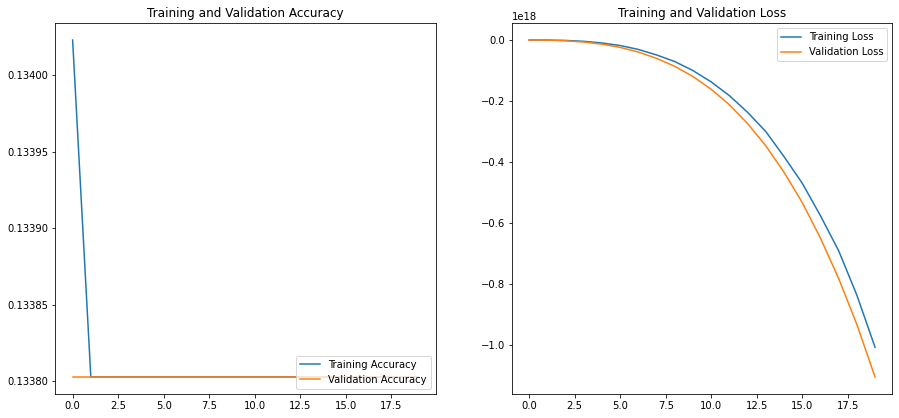

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
y_pred = model.predict(X_test)

In [56]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.21      1.00      0.35       300
           1       0.00      0.00      0.00       190
           2       0.00      0.00      0.00       300
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       260
           5       0.00      0.00      0.00       230

    accuracy                           0.21      1420
   macro avg       0.04      0.17      0.06      1420
weighted avg       0.04      0.21      0.07      1420



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


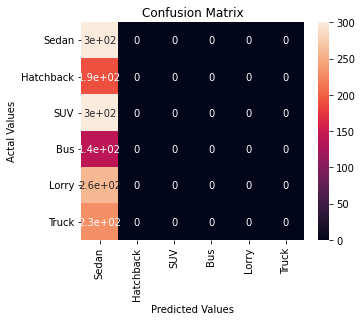

In [57]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()